In [55]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

In [6]:
df1 = pd.read_csv('1900_2021_DISASTERS.csv')
df2 = pd.read_csv('1970-2021_DISASTERS.csv')
df1.head()

,Year,Seq,Glide,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,Country,...,No Affected,No Homeless,Total Affected,Insured Damages ('000 US$),Total Damages ('000 US$),CPI,Adm Level,Admin1 Code,Admin2 Code,Geo Locations
0,1900,9002,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,Cabo Verde,...,NaN,NaN,NaN,NaN,NaN,3.221647,NaN,NaN,NaN,NaN
1,1900,9001,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,India,...,NaN,NaN,NaN,NaN,NaN,3.221647,NaN,NaN,NaN,NaN
2,1902,12,NaN,Natural,Geophysical,Earthquake,Ground movement,NaN,NaN,Guatemala,...,NaN,NaN,NaN,NaN,25000.0,3.350513,NaN,NaN,NaN,NaN
3,1902,3,NaN,Natural,Geophysical,Volcanic activity,Ash fall,NaN,Santa Maria,Guatemala,...,NaN,NaN,NaN,NaN,NaN,3.350513,NaN,NaN,NaN,NaN
4,1902,10,NaN,Natural,Geophysical,Volcanic activity,Ash fall,NaN,Santa Maria,Guatemala,...,NaN,NaN,NaN,NaN,NaN,3.350513,NaN,NaN,NaN,NaN


In [19]:
df1.columns

Index(['Year', 'Seq', 'Glide', 'Disaster Group', 'Disaster Subgroup',
       'Disaster Type', 'Disaster Subtype', 'Disaster Subsubtype',
       'Event Name', 'Country', 'ISO', 'Region', 'Continent', 'Location',
       'Origin', 'Associated Dis', 'Associated Dis2', 'OFDA Response',
       'Appeal', 'Declaration', 'Aid Contribution', 'Dis Mag Value',
       'Dis Mag Scale', 'Latitude', 'Longitude', 'Local Time', 'River Basin',
       'Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month',
       'End Day', 'Total Deaths', 'No Injured', 'No Affected', 'No Homeless',
       'Total Affected', 'Insured Damages ('000 US$)',
       'Total Damages ('000 US$)', 'CPI', 'Adm Level', 'Admin1 Code',
       'Admin2 Code', 'Geo Locations'],
      dtype='object')

In [27]:
cols_dict = {'Total Damages (\'000 US$)':'ttl_usd_damages',
             'Insured Damages (\'000 US$)':'ins_usd_damages',
             }
df1.rename(columns=cols_dict,inplace=True)
df1.columns

Index(['Year', 'Seq', 'Glide', 'Disaster Group', 'Disaster Subgroup',
       'Disaster Type', 'Disaster Subtype', 'Disaster Subsubtype',
       'Event Name', 'Country', 'ISO', 'Region', 'Continent', 'Location',
       'Origin', 'Associated Dis', 'Associated Dis2', 'OFDA Response',
       'Appeal', 'Declaration', 'Aid Contribution', 'Dis Mag Value',
       'Dis Mag Scale', 'Latitude', 'Longitude', 'Local Time', 'River Basin',
       'Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month',
       'End Day', 'Total Deaths', 'No Injured', 'No Affected', 'No Homeless',
       'Total Affected', 'ins_usd_damages', 'ttl_usd_damages', 'CPI',
       'Adm Level', 'Admin1 Code', 'Admin2 Code', 'Geo Locations'],
      dtype='object')

In [28]:
df1['ttl_adj_usd_damages'] = df1['CPI'] * df1['ttl_usd_damages']
df1['ins_adj_usd_damages'] = df1['CPI'] * df1['ins_usd_damages']

In [29]:
df = pd.pivot_table(data=df1,
               index=['Year','Region'],
               values=['No Injured','No Affected','No Homeless','Total Deaths','CPI',
                       'ins_adj_usd_damages','ttl_adj_usd_damages'],
               aggfunc=np.sum).reset_index()
df.head()

,Year,Region,CPI,No Affected,No Homeless,No Injured,Total Deaths,ins_adj_usd_damages,ttl_adj_usd_damages
0,1900,Caribbean,6.443295,0.0,0.0,0.0,330.0,0.0,0.00000
1,1900,Eastern Asia,3.221647,0.0,0.0,0.0,30.0,0.0,0.00000
2,1900,Northern America,3.221647,0.0,0.0,0.0,6000.0,0.0,96649.41813
3,1900,Southern Asia,3.221647,0.0,0.0,0.0,1250000.0,0.0,0.00000
4,1900,Western Africa,3.221647,0.0,0.0,0.0,11000.0,0.0,0.00000


In [31]:
df.Region.unique()

array(['Caribbean', 'Eastern Asia', 'Northern America', 'Southern Asia',
       'Western Africa', 'Western Asia', 'Eastern Africa',
       'Central America', 'Russian Federation', 'South-Eastern Asia',
       'Southern Europe', 'South America', 'Western Europe',
       'Eastern Europe', 'Northern Africa', 'Middle Africa',
       'Central Asia', 'Polynesia', 'Australia and New Zealand',
       'Melanesia', 'Northern Europe', 'Southern Africa', 'Micronesia'],
      dtype=object)

In [42]:
type(df.Year[0])

numpy.int64

In [48]:
df.Year = pd.to_datetime(df.Year, format='%Y')

14:23:58 - cmdstanpy - INFO - Chain [1] start processing
14:23:58 - cmdstanpy - INFO - Chain [1] done processing


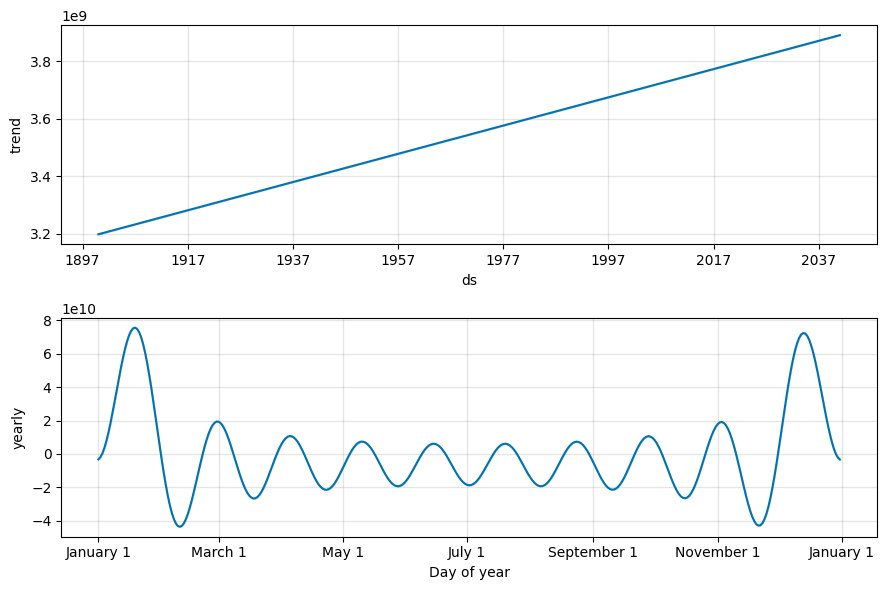

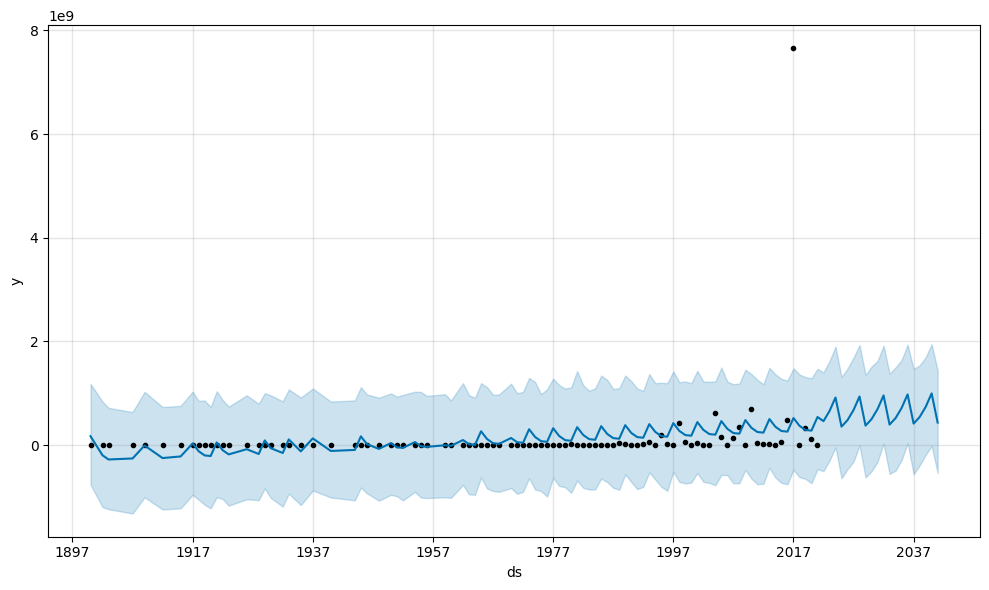

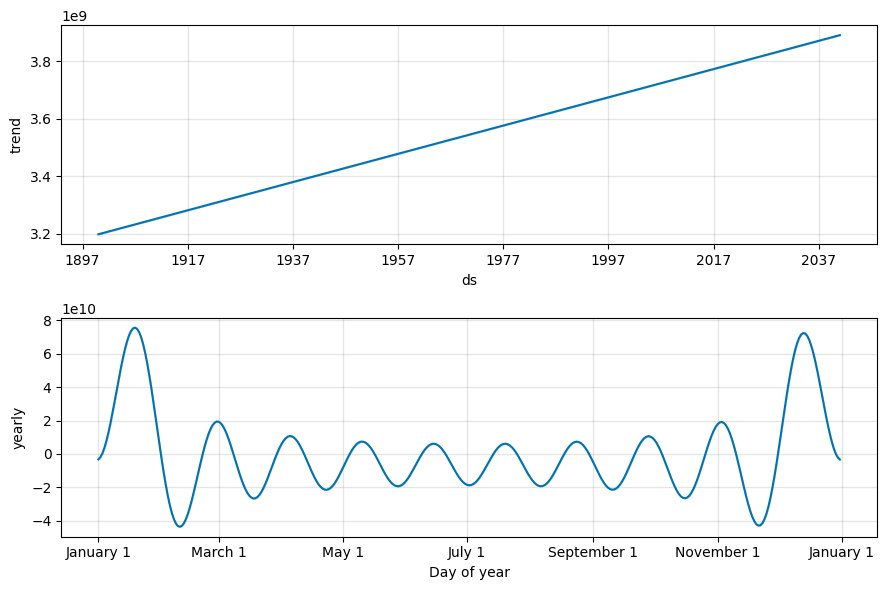

In [52]:
# Renombrar las columnas a 'ds' (fecha) y 'y' (valor)
data = df.loc[df.Region=='Caribbean', ['Year','ttl_adj_usd_damages']]
data = data.rename(columns={'Year': 'ds', 'ttl_adj_usd_damages': 'y'})

# Crear una instancia del modelo Prophet
modelo = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)

# Ajustar el modelo a los datos
modelo.fit(data)

# Generar fechas futuras para la predicción
futuro = modelo.make_future_dataframe(periods=20, freq='Y')  # Predicción para un año (365 días)

# Realizar la predicción
prediccion = modelo.predict(futuro)

# Visualizar la predicción
modelo.plot(prediccion)
modelo.plot_components(prediccion)

In [76]:
#data = data.rename(columns={'Year': 'df', 'valor': 'ttl_adj_usd_damages'})
prediccion

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1900-01-01,3.198608e+09,-7.618764e+08,1.181691e+09,3.198608e+09,3.198608e+09,-3.026240e+09,-3.026240e+09,-3.026240e+09,-3.026240e+09,-3.026240e+09,-3.026240e+09,0.0,0.0,0.0,1.723680e+08
1,1902-01-01,3.208407e+09,-1.194882e+09,8.419441e+08,3.208407e+09,3.208407e+09,-3.403722e+09,-3.403722e+09,-3.403722e+09,-3.403722e+09,-3.403722e+09,-3.403722e+09,0.0,0.0,0.0,-1.953144e+08
2,1903-01-01,3.213307e+09,-1.235881e+09,7.196152e+08,3.213307e+09,3.213307e+09,-3.489451e+09,-3.489451e+09,-3.489451e+09,-3.489451e+09,-3.489451e+09,-3.489451e+09,0.0,0.0,0.0,-2.761442e+08
3,1907-01-01,3.232918e+09,-1.317443e+09,6.385638e+08,3.232918e+09,3.232918e+09,-3.489451e+09,-3.489451e+09,-3.489451e+09,-3.489451e+09,-3.489451e+09,-3.489451e+09,0.0,0.0,0.0,-2.565329e+08
4,1909-01-01,3.242730e+09,-1.005812e+09,1.029177e+09,3.242730e+09,3.242730e+09,-3.249243e+09,-3.249243e+09,-3.249243e+09,-3.249243e+09,-3.249243e+09,-3.249243e+09,0.0,0.0,0.0,-6.513209e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,2036-12-31,3.870465e+09,-5.613997e+08,1.467604e+09,3.870462e+09,3.870469e+09,-3.454367e+09,-3.454367e+09,-3.454367e+09,-3.454367e+09,-3.454367e+09,-3.454367e+09,0.0,0.0,0.0,4.160985e+08
110,2037-12-31,3.875368e+09,-3.916258e+08,1.538574e+09,3.875364e+09,3.875372e+09,-3.333705e+09,-3.333705e+09,-3.333705e+09,-3.333705e+09,-3.333705e+09,-3.333705e+09,0.0,0.0,0.0,5.416623e+08
111,2038-12-31,3.880270e+09,-1.897818e+08,1.693783e+09,3.880266e+09,3.880275e+09,-3.144600e+09,-3.144600e+09,-3.144600e+09,-3.144600e+09,-3.144600e+09,-3.144600e+09,0.0,0.0,0.0,7.356706e+08
112,2039-12-31,3.885173e+09,-1.624768e+07,1.947300e+09,3.885168e+09,3.885178e+09,-2.887425e+09,-2.887425e+09,-2.887425e+09,-2.887425e+09,-2.887425e+09,-2.887425e+09,0.0,0.0,0.0,9.977478e+08


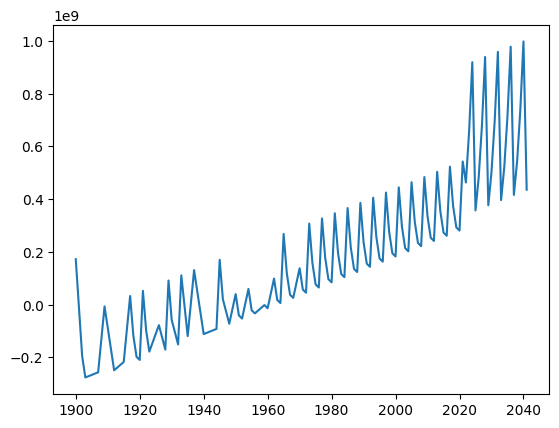

In [56]:
plt.plot(prediccion['ds'],prediccion['yhat'])

In [77]:
def predict_variable(df, vars, periods):
    results = {}
    idx = 0
    for var in vars:
        final = {}
        for region in df.Region.unique():
            data = df.loc[df.Region==region, ['Year',var]]
            data = data.rename(columns={'Year': 'ds', var: 'y'})
            modelo = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
            modelo.fit(data)
            futuro = modelo.make_future_dataframe(periods=periods, freq='Y')
            prediccion = modelo.predict(futuro)
            prediccion['variable'] = var
            prediccion['region'] = region
            results[idx] = prediccion
            idx = idx + 1
    return results

In [78]:
vars = ['No Injured','No Affected','No Homeless','Total Deaths','CPI', 'ins_adj_usd_damages','ttl_adj_usd_damages']
results = predict_variable(df, vars, 30)

14:51:48 - cmdstanpy - INFO - Chain [1] start processing
14:51:49 - cmdstanpy - INFO - Chain [1] done processing
14:51:49 - cmdstanpy - INFO - Chain [1] start processing
14:51:49 - cmdstanpy - INFO - Chain [1] done processing
14:51:49 - cmdstanpy - INFO - Chain [1] start processing
14:51:49 - cmdstanpy - INFO - Chain [1] done processing
14:51:50 - cmdstanpy - INFO - Chain [1] start processing
14:51:50 - cmdstanpy - INFO - Chain [1] done processing
14:51:50 - cmdstanpy - INFO - Chain [1] start processing
14:51:50 - cmdstanpy - INFO - Chain [1] done processing
14:51:50 - cmdstanpy - INFO - Chain [1] start processing
14:51:51 - cmdstanpy - INFO - Chain [1] done processing
14:51:51 - cmdstanpy - INFO - Chain [1] start processing
14:51:51 - cmdstanpy - INFO - Chain [1] done processing
14:51:51 - cmdstanpy - INFO - Chain [1] start processing
14:51:52 - cmdstanpy - INFO - Chain [1] done processing
14:51:52 - cmdstanpy - INFO - Chain [1] start processing
14:51:52 - cmdstanpy - INFO - Chain [1]

In [80]:
results

{0:             ds          trend     yhat_lower    yhat_upper    trend_lower  \
 0   1900-01-01 -235818.962352  -84255.414825  60831.968889 -235818.962352   
 1   1902-01-01 -235348.876656  -81540.640459  74737.249567 -235348.876656   
 2   1903-01-01 -235113.833807  -83248.692559  64166.595133 -235113.833807   
 3   1907-01-01 -234173.018462  -82473.018668  66141.848021 -234173.018462   
 4   1909-01-01 -233702.288814  -80179.103327  74340.764123 -233702.288814   
 ..         ...            ...            ...           ...            ...   
 119 2046-12-31 -201245.069335 -104926.952387  39353.898239 -201245.074265   
 120 2047-12-31 -201010.025548 -134115.353607  15409.801541 -201010.030776   
 121 2048-12-31 -200774.337805  -76341.279765  81096.970047 -200774.343298   
 122 2049-12-31 -200539.294018  -83542.353298  68154.423525 -200539.299906   
 123 2050-12-31 -200304.250230 -112758.652968  45835.530201 -200304.256406   
 
        trend_upper  additive_terms  additive_terms_lower  

In [81]:

final = pd.concat(results)
final = final.loc[final.ds > pd.to_datetime("2021-01-01"),:]
final.head()

ds          trend     yhat_lower    yhat_upper    trend_lower  \
0 94 2021-12-31 -207125.027753  -90936.543533  59400.717299 -207125.027753   
  95 2022-12-31 -206889.983966 -116061.227794  36883.420493 -206889.984004   
  96 2023-12-31 -206654.940178 -141751.313636   4477.543803 -206654.940284   
  97 2024-12-31 -206419.252436  -70545.947462  73303.151632 -206419.252634   
  98 2025-12-31 -206184.208648  -89216.202392  55565.772468 -206184.208950   

        trend_upper  additive_terms  additive_terms_lower  \
0 94 -207125.027753   189014.246637         189014.246637   
  95 -206889.983925   166136.473797         166136.473797   
  96 -206654.940076   138326.758548         138326.758548   
  97 -206419.252243   206920.483256         206920.483256   
  98 -206184.208377   189014.246637         189014.246637   

      additive_terms_upper         yearly   yearly_lower   yearly_upper  \
0 94         189014.246637  189014.246637  189014.246637  189014.246637   
  95         166136.473797  166136.473797  166136.473797  166136.473797   
  96         138326.758548  138326.758548  138326.758548  138326.758548   
  97         206920.483256  206920.483256  206920.483256  206920.483256   
  98         189014.246637  189014.246637  189014.246637  189014.246637   

      multiplicative_terms  multiplicative_terms_lower  \
0 94                   0.0                         0.0   
  95                   0.0                         0.0   
  96                   0.0                         0.0   
  97                   0.0                         0.0   
  98                   0.0                         0.0   

      multiplicative_terms_upper          yhat    variable     region  
0 94                         0.0 -18110.781116  No Injured  Caribbean  
  95                         0.0 -40753.510169  No Injured  Caribbean  
  96                         0.0 -68328.181631  No Injured  Caribbean  
  97                         0.0    501.230820  No Injured  Caribbean  
  98                         0.0 -17169.962011  No Injured  Caribbean

In [83]:
final.region.unique()

array(['Caribbean', 'Eastern Asia', 'Northern America', 'Southern Asia',
       'Western Africa', 'Western Asia', 'Eastern Africa',
       'Central America', 'South-Eastern Asia', 'Southern Europe',
       'South America', 'Western Europe', 'Eastern Europe',
       'Northern Africa', 'Middle Africa', 'Central Asia', 'Polynesia',
       'Australia and New Zealand', 'Melanesia', 'Northern Europe',
       'Southern Africa', 'Micronesia'], dtype=object)

In [85]:
final.variable.unique()

array(['No Injured', 'No Affected', 'No Homeless', 'Total Deaths', 'CPI',
       'ins_adj_usd_damages', 'ttl_adj_usd_damages'], dtype=object)

In [84]:
final.to_csv('predictions_v0.csv', index=False)